In [1]:
import os
import numpy as np
import pandas as pd
import array
import mmap
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy import signal as ss
from scipy import stats as st
from obspy.signal.filter import highpass
from obspy.signal.filter import bandpass
sep = '/'

In [2]:
kilosort_folder = '/Users/sharplab/tran/cat/Tran'
recording = '2018-04-12_371b'
path = sep.join([kilosort_folder, recording, recording+'.dat'])
figpath = sep.join([kilosort_folder, recording, recording+'.png'])
data = np.memmap(path, shape=(241320960,32), dtype = np.int16)

In [3]:
sep.join([kilosort_folder, recording, recording+'.dat'])

'/Users/sharplab/tran/cat/Tran/2018-04-12_371b/2018-04-12_371b.dat'

In [4]:
def load_kilosort_arrays(recording):
    spike_clusters = np.load('spike_clusters.npy')
    spike_times = np.load('spike_times.npy')
    cluster_groups = pd.read_csv('cluster_groups.csv', sep='\t')
    try:  # check data quality
        assert np.shape(spike_times.flatten()) == np.shape(spike_clusters)
    except AssertionError:
        AssertionError('Array lengths do not match in recording {}'.format(
            recording))
    return spike_clusters, spike_times, cluster_groups

def load_data(recording, kilosort_folder, verbose, sep):
    if verbose:
        print('\nLoading Data:\t{}\n'.format(recording))
        os.chdir(sep.join([kilosort_folder, recording]))
        spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(
            recording)
    return spike_clusters, spike_times, cluster_groups

def get_good_cluster_numbers(cluster_groups_df):
    good_clusters_df = cluster_groups_df.loc[cluster_groups_df['group'] == 'good', :]
    return good_clusters_df['cluster_id'].values

spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                        kilosort_folder=kilosort_folder,
                                                        verbose=True,
                                                        sep=sep)




Loading Data:	2018-04-12_371b



In [5]:
time_span = 1
num_samples_in_trace= time_span*30000


In [6]:
good_cluster_numbers = get_good_cluster_numbers(cluster_groups)
df = pd.DataFrame({'cluster':spike_clusters.flatten(), 'spike_times':spike_times.flatten()})
df = df.loc[df['cluster'].isin(good_cluster_numbers)]


In [7]:
cluster_to_plot = good_cluster_numbers[1]
print('Cluster ID: '+ str(cluster_to_plot))
extracted_spikes = df[df['cluster']==cluster_to_plot]['spike_times']

Cluster ID: 2


In [8]:
def band_passfilter(fs, low=None, high=None, order=None):
    low = low/(fs/2)
    high = high/(fs/2)
    return ss.butter(N=order, Wn=(low, high), btype='pass')

def apply_filter(array, low, high, fs, order, axis=-1):
    b,a = band_passfilter(fs=fs, low=low, high=high, order=order)
    return ss.filtfilt(b, a, array, axis=axis)
    

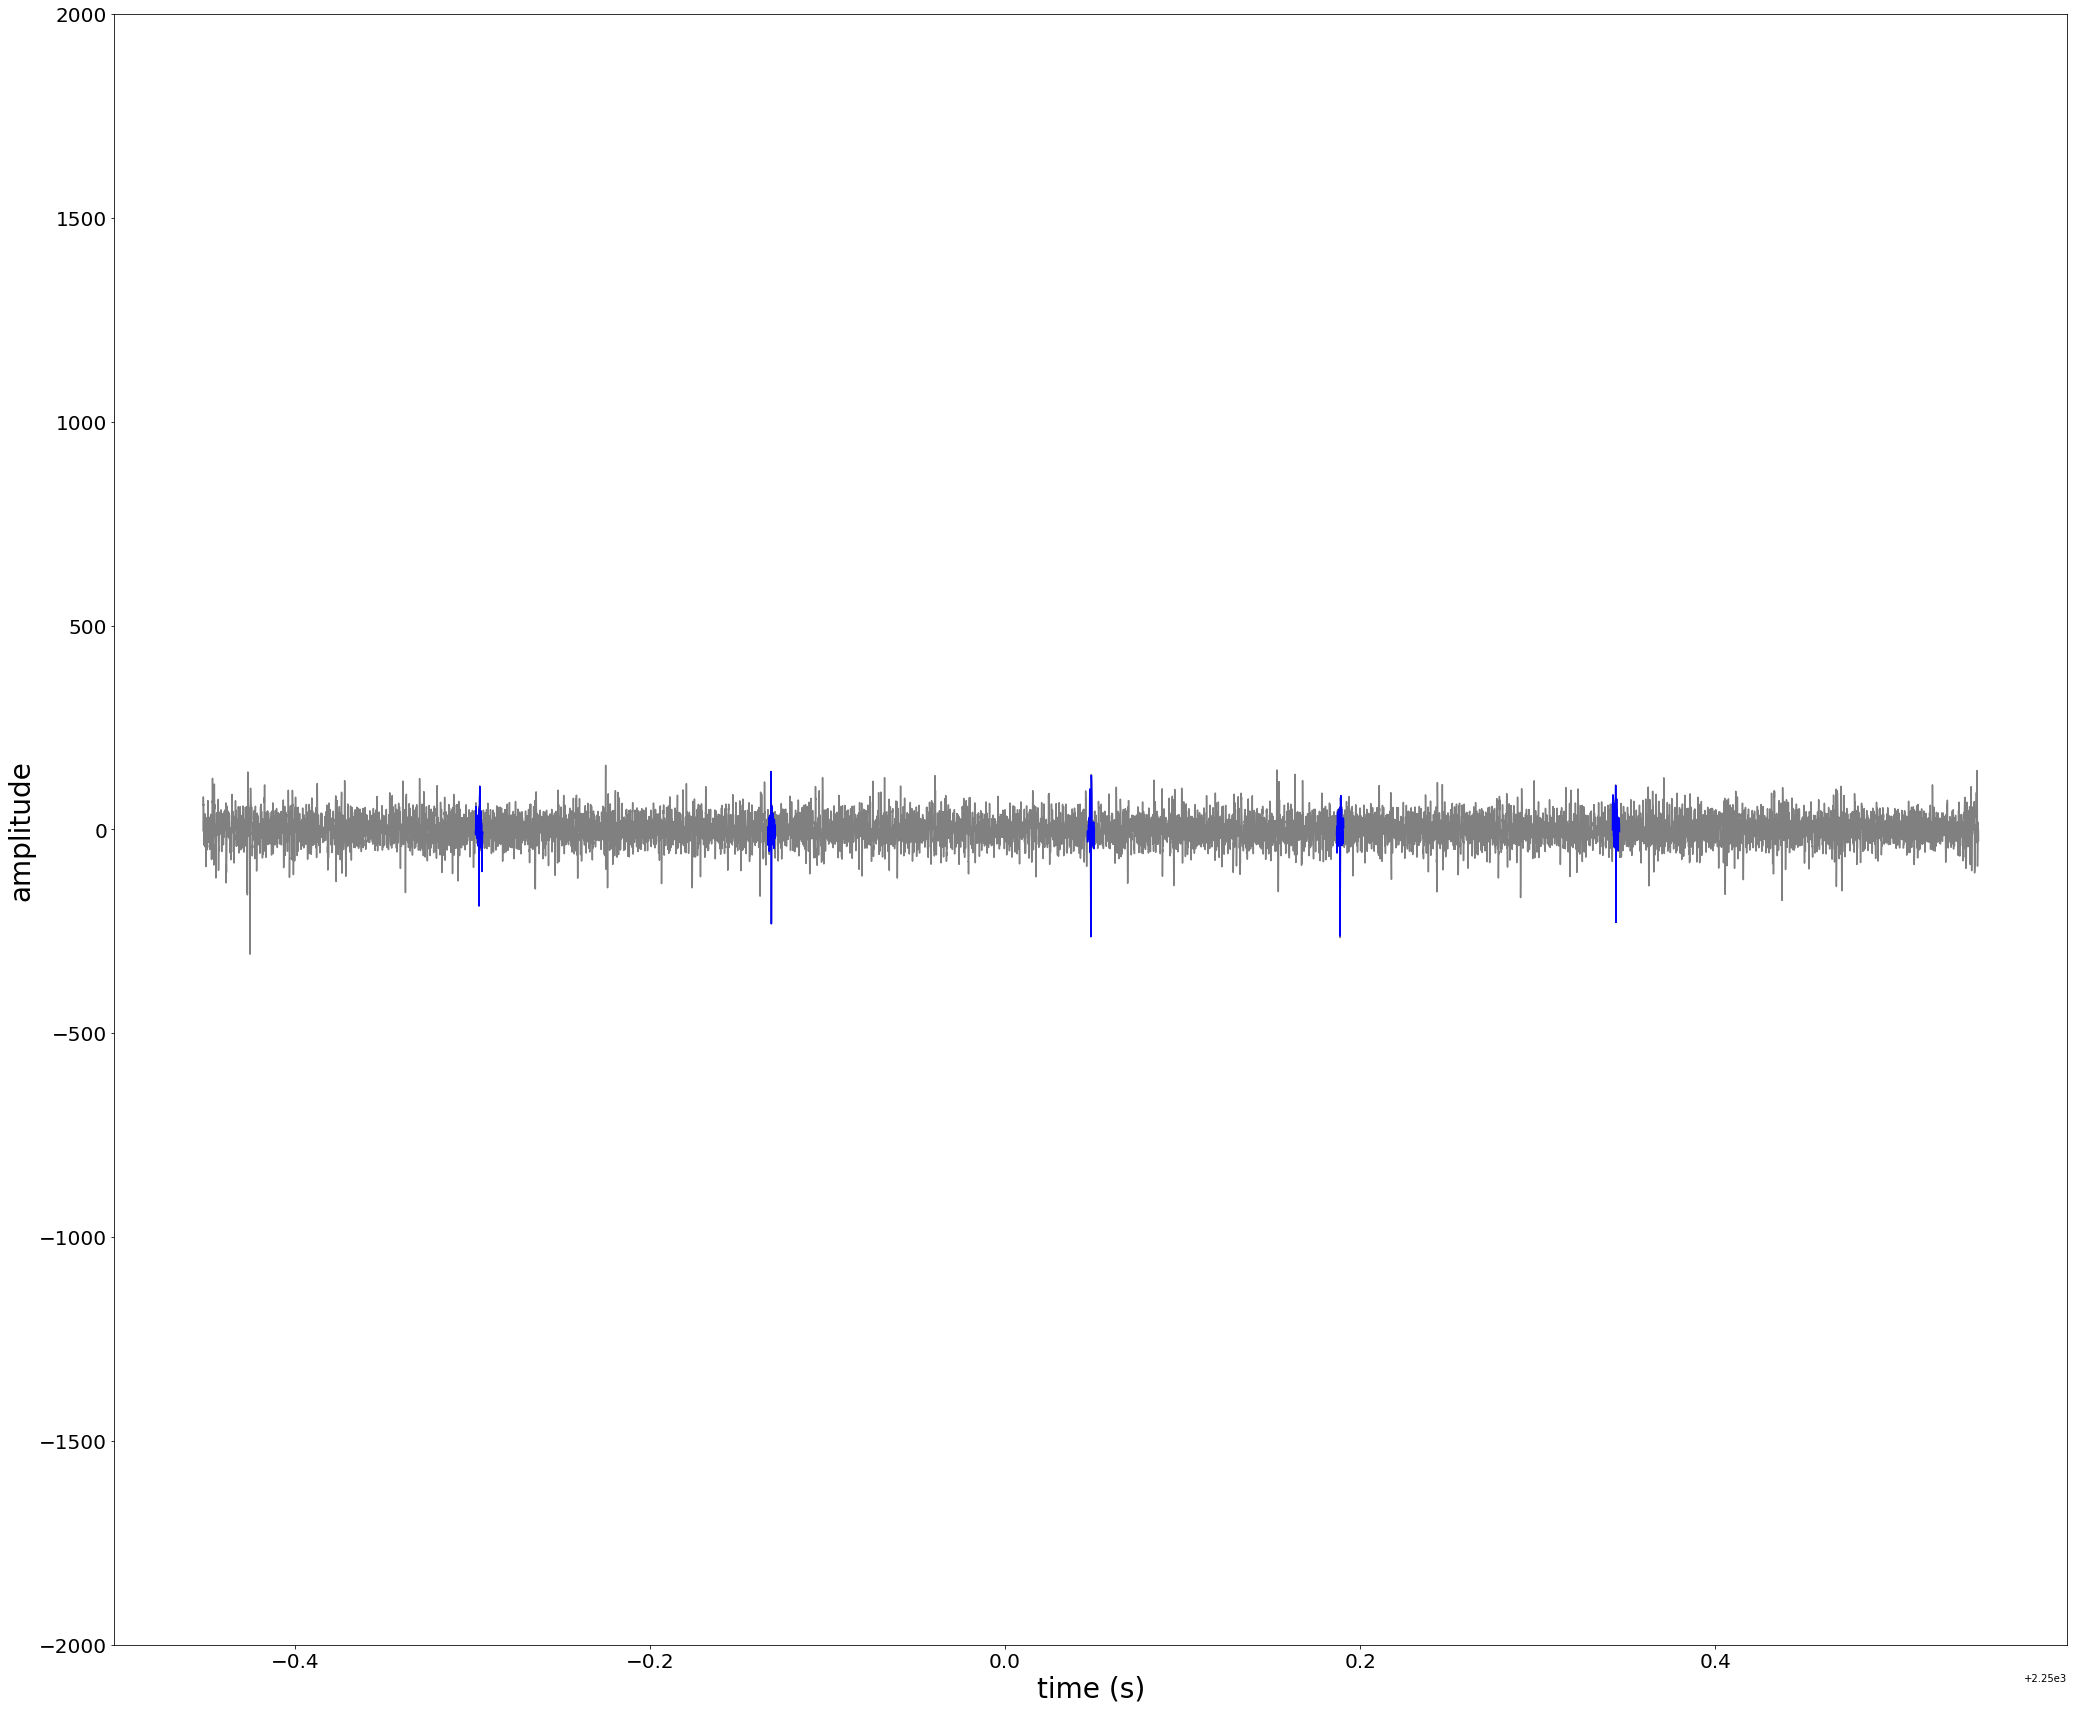

In [31]:

time_chosen = 2250
Spike_chosen = (extracted_spikes-time_chosen*30000).abs().argsort()[:1]
channel_chosen = 26

plt.figure(figsize=(35,30))


waveform_window = np.arange(int(-num_samples_in_trace/2),int(num_samples_in_trace/2))


start_index = int(extracted_spikes.iloc[Spike_chosen]+waveform_window[0])  
end_index = int((extracted_spikes.iloc[Spike_chosen]+waveform_window[-1])+1)


filtered_data = apply_filter(array=data[start_index:end_index, channel_chosen], low=400, high=6000, fs=30000, order=4)

df_wave= pd.DataFrame({'Values':filtered_data})
df_wave['time'] = np.arange(start_index, end_index, 1)

df_final = pd.DataFrame({'time':df_wave['time']/30000, 'Value':df_wave['Values']})



plt.plot(df_final['time'], df_final['Value'], color='gray')




for spike in np.arange(Spike_chosen-2, Spike_chosen+3):
    
    window_for_highlight = np.arange(-60,60)
    
    start_highlight= int(extracted_spikes.iloc[spike]+window_for_highlight[0])
    end_highlight = int((extracted_spikes.iloc[spike]+window_for_highlight[-1])+1)
    
    filtered_highlight_data= apply_filter(array=data[start_highlight:end_highlight, channel_chosen], low=400, high=6000, fs=30000, order=4)
    
    
    df_highlight = pd.DataFrame({'Values':filtered_highlight_data})
    df_highlight['time'] = np.arange(start_highlight, end_highlight, 1)
    df_highlight_final = pd.DataFrame({'time':df_highlight['time']/30000, 'Value':df_highlight['Values']})
    plt.plot(df_highlight_final['time'], df_highlight_final['Value'], color='b')

plt.ylim(-2000, 2000)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('time (s)', fontsize=28)
plt.ylabel('amplitude', fontsize=28)
plt.savefig(figpath)
plt.show()

In [34]:
test_df=pd.DataFrame(data[start_index:end_index])
for chan in [22]:
    test_df.drop((chan), inplace=True, axis=1)
mins = test_df.apply(np.min, axis=0)
chosen_channel = mins.idxmin()
test_df

,0,1,2,3,4,5,6,7,8,9,...,21,23,24,25,26,27,28,29,30,31
0,67,-7,69,-138,-36,-211,-62,-347,-105,-24,...,8,-4,-44,-16,-63,-26,-44,-95,-78,-1
1,20,-20,18,-207,-94,-339,-68,-344,-111,10,...,-21,-24,38,-43,-52,17,-75,-74,-59,-4
2,35,-122,7,-312,-59,-500,-73,-361,-111,-41,...,-69,-54,65,-19,-6,24,-80,-47,-36,48
3,57,-139,-22,-408,-151,-765,-71,-415,-171,-103,...,-15,-11,60,6,15,39,-10,-5,42,94
4,46,-165,-115,-442,-261,-861,-189,-374,-136,8,...,90,-2,101,34,11,92,-10,17,31,132
5,100,-142,-132,-404,-333,-671,-293,-313,-95,26,...,19,20,80,21,-1,39,-39,19,23,81
6,28,-169,-127,-399,-288,-573,-304,-229,-27,27,...,2,6,57,-25,-17,53,18,30,-13,83
7,3,-186,-107,-300,-289,-478,-218,-169,-39,45,...,42,-1,45,17,-32,34,20,-13,-10,95
8,-27,-165,-207,-290,-286,-377,-194,-142,-90,71,...,3,16,58,36,-6,35,-11,2,-93,44
9,-50,-224,-171,-232,-193,-315,-195,-168,-2,113,...,-11,1,4,60,-2,29,-59,-34,-70,44


In [ ]:
df_wave

In [ ]:
pd.DataFrame(data)

In [ ]:

data.shape

In [ ]:
broken_chans = [22]
for chan in broken_chans:
    pd.DataFrame(data.drop(chan), inplace=True, axis=1)

In [ ]:
chosen_channel= 22
window_for_highlight = np.arange(-60, 60)
start_highlight = int(extracted_spikes.iloc[spike] + window_for_highlight[0])
end_highlight = int((extracted_spikes.iloc[spike] + window_for_highlight[-1]) + 1)
filtered_highlight_data = apply_filter(array=data[start_highlight:end_highlight, chosen_channel], low=400, high=6000, fs=30000, order=4)
df_highlight = pd.DataFrame({'Value': filtered_highlight_data})
print(df_highlight.shape)
df_highlight['time'] = np.arange(start_highlight / 30000, end_highlight / 30000, 1 / 30000)
len(np.arange(start_highlight / 30000, end_highlight / 30000, 1 / 30000))

In [ ]:
num_samples_in_trace = time_span * 30000
waveform_window = np.arange(int(-num_samples_in_trace / 2), int(num_samples_in_trace / 2))
start_index = int(extracted_spikes.iloc[Spike_chosen] + waveform_window[0])
end_index = int((extracted_spikes.iloc[Spike_chosen] + waveform_window[-1]) + 1)
temporary_df = pd.DataFrame(data[start_index:end_index])
mins = temporary_df.apply(np.min, axis=0)
chosen_channel = mins.idxmin()
chosen_channel

In [ ]:
def extract_trace(Spike_chosen, extracted_spikes, num_samples_in_trace, data):
    waveform_window = np.arange(int(-num_samples_in_trace/2),int(num_samples_in_trace/2))
    start_index = int(extracted_spikes.iloc[Spike_chosen]+waveform_window[0])  
    end_index = int((extracted_spikes.iloc[Spike_chosen]+waveform_window[-1])+1)
    filtered_data = apply_filter(array=data[start_index:end_index, channel_chosen], low=400, high=6000, fs=30000, order=4)
    df_trace= pd.DataFrame({'Value':filtered_data})
    df_trace['time'] = np.arange(start_index/30000, end_index/30000, 1/30000)
    return df_trace

def spike_highlight(spike, extracted_spikes, data):
    window_for_highlight = np.arange(-60,60) 
    start_highlight= int(extracted_spikes.iloc[spike]+window_for_highlight[0])
    end_highlight = int((extracted_spikes.iloc[spike]+window_for_highlight[-1])+1)
    filtered_highlight_data= apply_filter(array=data[start_highlight:end_highlight, channel_chosen], low=400, high=6000, fs=30000, order=4)
    df_highlight = pd.DataFrame({'Values':filtered_highlight_data})
    df_highlight['time'] = np.arange(start_highlight, end_highlight, 1)
    df_highlight_final = pd.DataFrame({'time':df_highlight['time']/30000, 'Value':df_highlight['Values']})
    return df_highlight_final

In [ ]:
plt.figure(figsize=(35, 30))

    chosen_channel = choose_channel(Spike_chosen=Spike_chosen, extracted_spikes=extracted_spikes, time_span=ops.time_span, data=data)

    
    def plot_trace_data(Spike_chosen, extracted_spikes, time_span, data, chosen_channel):
        df_trace = extract_trace(Spike_chosen=Spike_chosen, extracted_spikes=extracted_spikes, time_span=ops.time_span, data=data, chosen_channel=26)
        plt.plot(df_trace['time'], df_trace['Value'], color='gray')

        for spike in np.arange(Spike_chosen - 2, Spike_chosen + 3):

            df_highlight = spike_highlight(spike=spike, extracted_spikes=extracted_spikes, data=data, chosen_channel=chosen_channel)
            plt.plot(df_highlight['time'], df_highlight['Value'], color='b')

        plt.ylim(-2000, 2000)
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.xlabel('time (s)', fontsize=28)
        plt.ylabel('amplitude', fontsize=28)
        figpath = os.path.join(kilosort_folder, recording, recording + '.png')
        plt.savefig(figpath)
        plt.show()



In [ ]:
window_for_highlight = np.arange(-10,10)
    
start_highlight= int(extracted_spikes.iloc[500]+window_for_highlight[0])
end_highlight = int((extracted_spikes.iloc[500]+window_for_highlight[-1])+1)
    
filtered_highlight_data= bandpass(data[start_highlight:end_highlight, :], freqmin, freqmax, df=30000, corners=4, zerophase=False)
    
waveform_highlight = filtered_highlight_data
df_highlight = pd.DataFrame(waveform_highlight, columns = cols)
df_highlight['time'] = np.arange(start_highlight, end_highlight, 1)
df_highlight_final = pd.DataFrame({'time':df_highlight['time']/30000, 'Value':df_highlight['Chan_30']})
plt.plot(df_highlight_final['time'], df_highlight_final['Value'], color='b')

In [ ]:
plt.plot(data[:60000])
plt.show()

## Todo
    - Take max of each column
    - Take min of each column
    - Take absolute value of the min and max per column
    - Find column that has the highest distance
    - Plot that column

In [ ]:
maxes = waveform_per_channel_df.apply(np.max, axis=0)

In [ ]:
lab = maxes.idxmax()

In [ ]:
maxes.idxmax()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
correct_chan = test_df.loc[:, 'Chan_4']
plt.figure(figsize = (25,1))
correct_chan.plot()
plt.show()

In [ ]:
correct_chan = correct_chan.reset_index()
correct_chan.columns = ['figure', 'y_values']
correct_chan.set_index('figure', inplace=True)

## Calculate half spike width
    - Convert x axis from samples to seconds or ms
    - Find the peak y value, store the x value (time) as a variable
    - Write an algorythm that detect when the y value stops decreases with decreasing x values
    - Return the x value at which this occurs
    - Calculate the distance in time between these points

In [ ]:
max_peak_time = correct_chan.idxmax()[0]
min_peak_time = correct_chan.idxmin()[0]
print(min_peak_time)

In [ ]:
correct_chan.loc[min_peak_time:60].idxmax()[0]

In [ ]:
reverse_counter = np.arange(max_peak_time, -1 ,-1)

counter = np.arange(max_peak_time, 60, 1)

from_min_to_second_max = np.arange(min_peak_time, correct_chan.loc[min_peak_time:60].idxmax()[0], 1)

from_second_max_to_end = np.arange(correct_chan.loc[min_peak_time:60].idxmax()[0], 60, 1)


In [ ]:
from_min_to_second_max

In [ ]:
baseline = []
return_point = []
second_max = []
last_point = []

time_list_2 = []

for reverse_time_point in reverse_counter:
    if correct_chan.loc[reverse_time_point][0] > (correct_chan.loc[max_peak_time][0]/20):
        baseline.append(reverse_time_point)
    else:
        pass

for time_point in counter:
    if correct_chan.loc[time_point][0] > (correct_chan.loc[max_peak_time][0]/20):
        time_list_2.append(time_point)
    else:
        pass

for return_time_point in from_min_to_second_max:
    if np.absolute(np.absolute(correct_chan.loc[return_time_point][0]) - correct_chan.loc[baseline[-1]][0])<(correct_chan.loc[baseline[-1]][0]/2):
        return_point.append(return_time_point)
    else:
        pass

for last_time_point in from_second_max_to_end:
    if np.absolute(np.absolute(correct_chan.loc[last_time_point][0]) - correct_chan.loc[baseline[-1]][0])<(correct_chan.loc[baseline[-1]][0]/10):
        last_point.append(last_time_point)
    else:
        pass

In [ ]:
plt.plot(correct_chan, linestyle=None, marker='.')
plt.plot(np.ones(5)*baseline[-1], np.linspace(-400, 650, 5), 'k')
#plt.plot(np.ones(5)*max_peak_time, np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*last_point[-1], np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*return_point[0], np.linspace(-400, 650, 5), 'k')

In [ ]:
print(correct_chan.loc[32][0])
print(correct_chan.loc[33][0])

gradient = []

## Calculate the full spike wide (to troff)
    - Find the minimum value
    - x value
    - calculate the diffference in time between the baseline and the mimum point

In [ ]:
print(min_peak_time)
print(max_peak_time)
print(correct_chan.loc[max_peak_time][0])
print(correct_chan.loc[min_peak_time][0])

Base